In [1]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.nn import functional as F

import src.dag_utils as dag_utils
from src.arch import DAGConv
from src.models import Model
from src.baselines_archs import GCNN_2L

SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

DAG created
Inverted: 0.005983591079711914
Dq obtained: 0.1461653709411621
GSO computed: 0.014957189559936523


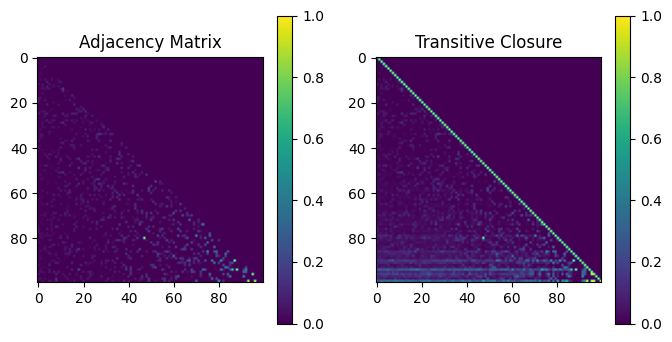

In [2]:
# Create graph
p = .2
N = 100

Adj, dag = dag_utils.create_dag(N, p)
assert nx.is_directed_acyclic_graph(dag), "Graph is not a DAG"

print("DAG created")

# Obtain GSOs
# TODO: accelerate creation og DAGs

t_i = time.time()
W = la.inv(np.eye(N) - Adj)
W_inf = la.inv(W)
print('Inverted:', time.time()-t_i)

Dq_list = []
t_i = time.time()
Dq_list = [dag_utils.compute_Dq(dag, i, N) for i in range(N)]
print('Dq obtained:', time.time()-t_i)

t_i = time.time()
GSOs = np.array([(W * Dq_list[i]) @ W_inf for i in range(N)])
print('GSO computed:', time.time()-t_i)

# Plot graph
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im1 = axs[0].imshow(Adj, cmap='viridis')
axs[0].set_title('Adjacency Matrix')
im2 = axs[1].imshow(W, cmap='viridis')
axs[1].set_title('Transitive Closure')
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])


# Example 1: modeling diffusion

In [3]:
# Create DATA
M = 5000
M_train = int(.7*M)
M_val = int(.2*M)
M_test = int(.1*M)
max_source = 8 #10
selected_gsos = 25

# Create sources and noise
X = np.zeros((M, N, 1))
idx = np.random.randint(0, max_source, M)
X[np.arange(M), idx] = 1


# Create filter
gsos_idx = np.random.randint(0, N, selected_gsos)
# filt_coefs = np.random.randn(selected_gsos)
filt_coefs = 2*np.random.rand(selected_gsos) - 1
# filt_coefs /= np.abs(filt_coefs).sum()
H = np.array([filt_coefs[i]*GSOs[idx] for i, idx in enumerate(gsos_idx)]).sum(axis=0)

# Create output signals, add noise and split into train, validation and test
Y = H @ X

X_t = torch.Tensor(X)
Y_t = torch.Tensor(Y)

X_data = {'train': X_t[:M_train], 'val': X_t[M_train:-M_test], 'test': X_t[-M_test:]}
Y_data = {'train': Y_t[:M_train], 'val': Y_t[M_train:-M_test], 'test': Y_t[-M_test:]}

print(X_data['train'].shape, ((Y_data['train']**2).sum()/M_train).item())
print(X_data['val'].shape)
print(X_data['test'].shape)


torch.Size([3500, 100, 1]) 5.798309326171875
torch.Size([1000, 100, 1])
torch.Size([500, 100, 1])


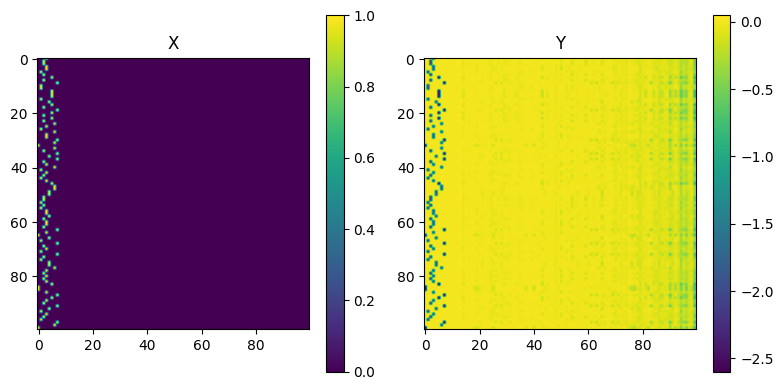

In [4]:
# Plot som data
fig, axes = plt.subplots(1, 2, figsize=(8,4))
img1  = axes[0].imshow(X[:N], cmap='viridis')
axes[0].set_title('X')
cbar1 = fig.colorbar(img1, ax=axes[0])
img2 = axes[1].imshow(Y[:N], cmap='viridis')
axes[1].set_title('Y')
cbar2 = fig.colorbar(img2, ax=axes[1])
plt.tight_layout()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create DAGConv model
in_dim = X.shape[2]
hid_dim = 32
out_dim = Y.shape[2]
L = 2
l_act = None #nn.Sigmoid()
loss = nn.MSELoss(reduction='mean')


X_train = torch.Tensor(X_data['train']).to(device)

# Training params
eval_freq = 1
batch_size = 50
lr = 1e-3 #1e-3
epochs = 35
patience = 3
wd = 1e-4

errs = {}
GSOs_tensor = torch.Tensor(GSOs)

print('DAGCNN')
arch = DAGConv(in_dim, hid_dim, out_dim, L, GSOs_tensor, last_act=l_act).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_dag = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                       patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG'] = model.test(X_data['test'], Y_data['test'])

print('DAGCNN WITH SELECTED GSOs')
sel_GSOs = GSOs_tensor[gsos_idx]
arch = DAGConv(in_dim, hid_dim, out_dim, L, sel_GSOs, last_act=l_act).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_dag_prior = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG-Prior'] = model.test(X_data['test'], Y_data['test'])

# NEED TO UPDATE BASELINE MODELS!
device = 'cpu'
l_act = nn.Identity() 

print('CLASSICAL GNN using A')
S = dgl.from_networkx(nx.from_numpy_array(Adj)).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S, act=nn.ReLU(), last_act=l_act)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-A'] = model.test(X_data['test'], Y_data['test'])

print('CLASSICAL GNN using W')
S = dgl.from_networkx(nx.from_numpy_array(W)).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S, act=nn.ReLU(), last_act=l_act)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnW = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-W'] = model.test(X_data['test'], Y_data['test'])

DAGCNN
Epoch 1/35 - Loss Train: 35.200 - Val Loss: 33.669
Epoch 2/35 - Loss Train: 0.640 - Val Loss: 0.605
Epoch 3/35 - Loss Train: 0.231 - Val Loss: 0.224
Epoch 4/35 - Loss Train: 0.157 - Val Loss: 0.153
Epoch 5/35 - Loss Train: 0.078 - Val Loss: 0.076
Epoch 6/35 - Loss Train: 0.034 - Val Loss: 0.034
Epoch 7/35 - Loss Train: 0.016 - Val Loss: 0.016
Epoch 8/35 - Loss Train: 0.010 - Val Loss: 0.011
Epoch 9/35 - Loss Train: 0.009 - Val Loss: 0.009
Epoch 10/35 - Loss Train: 0.008 - Val Loss: 0.009
Epoch 11/35 - Loss Train: 0.008 - Val Loss: 0.008
Epoch 12/35 - Loss Train: 0.008 - Val Loss: 0.008
Epoch 13/35 - Loss Train: 0.007 - Val Loss: 0.007
Epoch 14/35 - Loss Train: 0.007 - Val Loss: 0.007
Epoch 15/35 - Loss Train: 0.006 - Val Loss: 0.007
Epoch 16/35 - Loss Train: 0.006 - Val Loss: 0.006
Epoch 17/35 - Loss Train: 0.006 - Val Loss: 0.006
Epoch 18/35 - Loss Train: 0.006 - Val Loss: 0.006
Epoch 19/35 - Loss Train: 0.005 - Val Loss: 0.006
Epoch 20/35 - Loss Train: 0.005 - Val Loss: 0.005


- DAG: Mean err: 0.102 Std: 0.028
- DAG-Prior: Mean err: 0.036 Std: 0.009
- GNN-A: Mean err: 0.551 Std: 0.044
- GNN-W: Mean err: 0.916 Std: 0.007


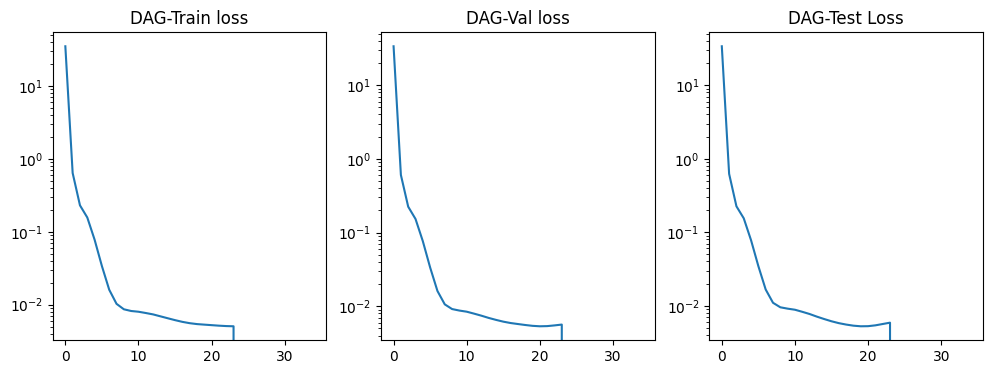

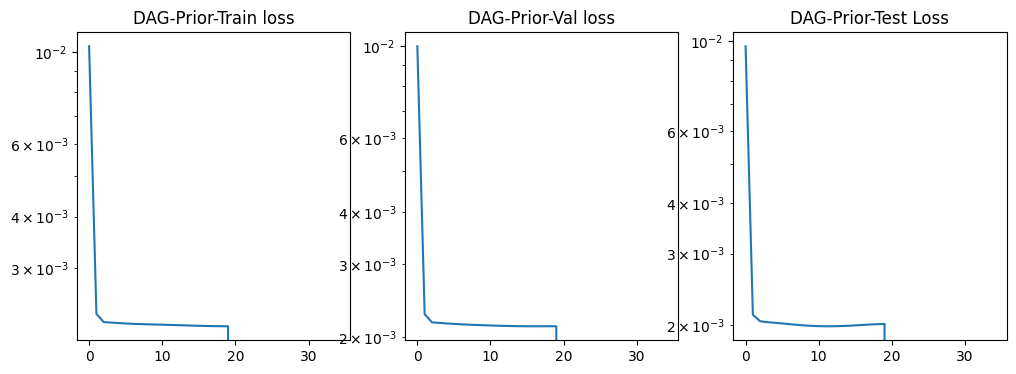

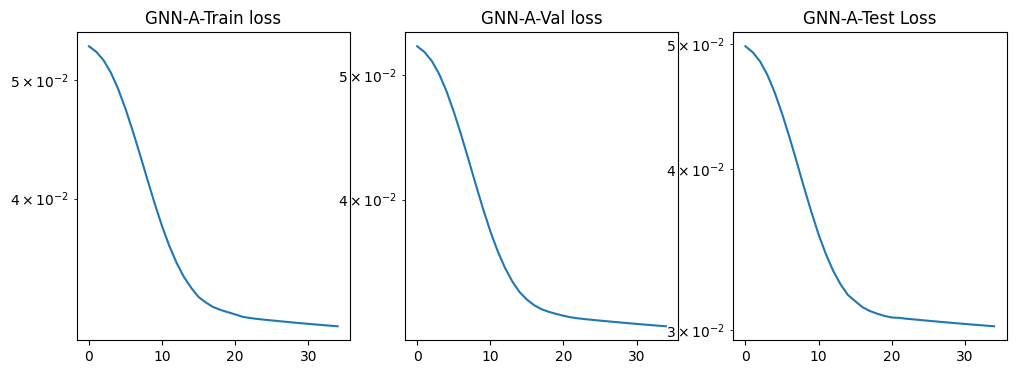

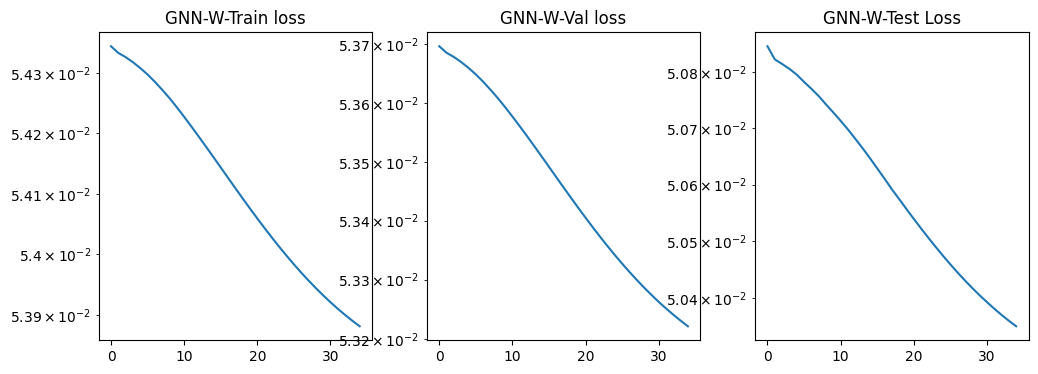

In [6]:
for key, value in errs.items():
    print(f'- {key}: Mean err: {value[0]:.3f} Std: {value[1]:.3f}')

losses = {'DAG': losses_dag, 'DAG-Prior': losses_dag_prior, 'GNN-A': losses_gnnA,
           'GNN-W': losses_gnnW}

for key, value in losses.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(value['train'])
    plt.title(f'{key}-Train loss')
    plt.subplot(1,3,2)
    plt.semilogy(value['val'])
    plt.title(f'{key}-Val loss')
    plt.subplot(1,3,3)
    plt.semilogy(value['test'])
    plt.title(f'{key}-Test Loss')


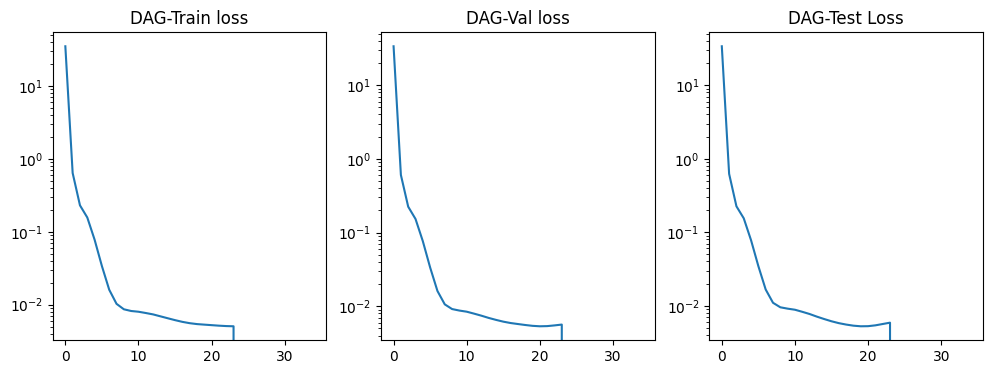

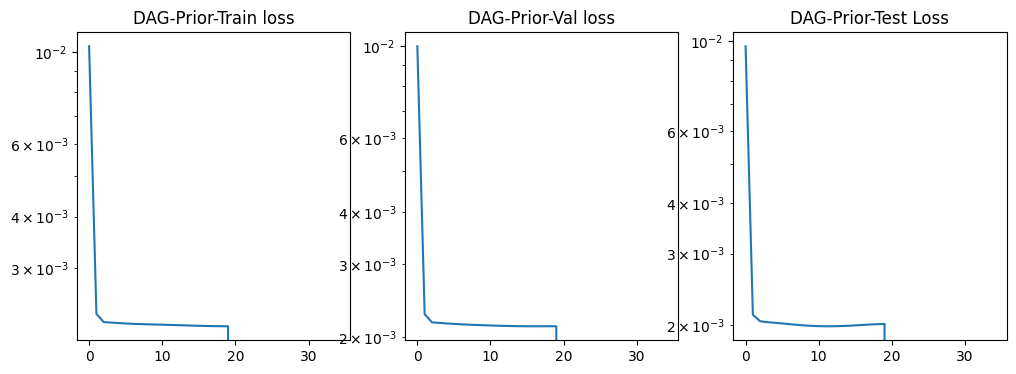

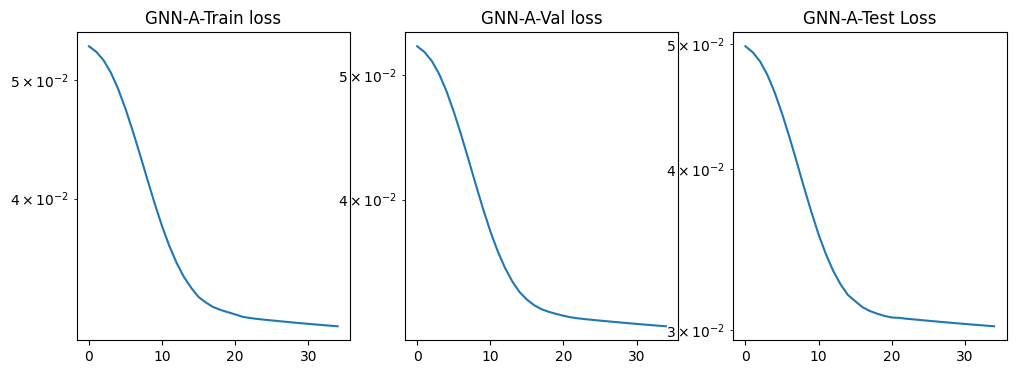

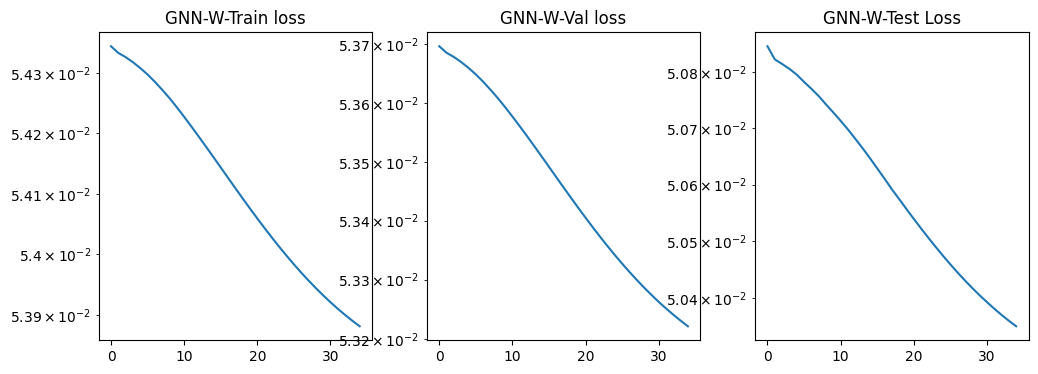

In [7]:
results = {'DAG': losses_dag, 'DAG-Prior': losses_dag_prior, 'GNN-A': losses_gnnA,
           'GNN-W': losses_gnnW}

# results = {'GNN-W': losses_gnnW,
#            'GNN-A': losses_gnnA}

for key, value in results.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(value['train'])
    plt.title(f'{key}-Train loss')
    plt.subplot(1,3,2)
    plt.semilogy(value['val'])
    plt.title(f'{key}-Val loss')
    plt.subplot(1,3,3)
    plt.semilogy(value['test'])
    plt.title(f'{key}-Test Loss')


In [8]:
# Plot results

# Example 2: source identification